In [1]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
from collections import Counter
from scipy.stats import shapiro
from scipy.stats import levene
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu

# Set seed for reproducibility
np.random.seed(42)

In [2]:
def average_precision_at_k_subtype(row, k):
    relevant_count = 0
    precision_sum = 0
    for i in range(1, k+1):
        ret_site = row[f'ret_{i}_diagnosis']
        if ret_site is None:
            continue
        if ret_site == row['query_diagnosis']:
            relevant_count += 1
            precision_sum += relevant_count / i
    if relevant_count == 0:
        return 0
    return precision_sum / min(k, relevant_count)

def majority_voting_at_k_subtype(row, k):
    votes = []
    for i in range(1, k+1):
        ret_site = row[f'ret_{i}_diagnosis']
        if pd.isnull(ret_site):
            votes.append(-1)
        else:
            votes.append(ret_site)
    if not votes:
        return 0
    counter = Counter(votes)
    most_common = counter.most_common(1)
    if most_common[0][0] == row['query_diagnosis']:
        return 1
    elif most_common[0][0] == -1:
        return None
    else:
        return 0

def average_precision_at_k_site(row, k):
    relevant_count = 0
    precision_sum = 0
    for i in range(1, k+1):
        ret_site = row[f'ret_{i}_site']
        if ret_site is None:
            continue
        if ret_site == row['query_site']:
            relevant_count += 1
            precision_sum += relevant_count / i
    if relevant_count == 0:
        return 0
    return precision_sum / min(k, relevant_count)

def majority_voting_at_k_site(row, k):
    votes = []
    for i in range(1, k+1):
        ret_site = row[f'ret_{i}_site']
        if pd.isnull(ret_site):
            votes.append(-1)
        else:
            votes.append(ret_site)
    if not votes:
        return 0
    counter = Counter(votes)
    most_common = counter.most_common(1)
    if most_common[0][0] == row['query_site']:
        return 1
    elif most_common[0][0] == -1:
        return None
    else:
        return 0

## Mann-Whitney U Test Explanation

The **Mann-Whitney U Test**, also known as the Wilcoxon rank-sum test, is a non-parametric statistical method used to ascertain whether two independent samples likely stem from the same distribution. Within the scope of this study, we're comparing performance scores of images derived from two distinct scanners. The goal here is to evaluate if there's a discernible difference in the algorithm's performance relative to the scanner in use. A lack of a notable difference could suggest that the algorithm showcases resilience against potential disparities ushered in by different scanning apparatuses.

### Key Considerations:
- **Independence of the Sets**: The two sets of images from different scanners are independent and unrelated.
  
- **Non-parametric Nature**: The Mann-Whitney U Test does not operate under the assumption that the data originates from a particular distribution. This makes it an excellent fit for data that doesn't necessarily abide by the normal distribution or when the sample size is not robust enough to draw reliable conclusions about the distribution.

- **Emphasis on Ranks**: Instead of the raw data values themselves, this test pivots on the ranks attributed to the data. As such, it examines the order or ranking of the data and not its actual values.

### Why Use This Test?
When the standard assumptions of the independent T-test (such as normality) are not met, the Mann-Whitney U Test steps in as a potent alternative. It's designed to provide valuable insights, especially when dealing with data that might not fit neatly into the normal distribution paradigm. By investigating the rank order of two datasets, it can pinpoint whether there exists a statistically significant difference in the underlying distributions of the two groups.


### Data Loading

In [3]:
model = "yottixel"

df_Leica_site = pd.read_csv(f"../../data/{model}/GBM_MICROSCOPE_CPTAC/site.csv")
df_Hamamatsu_site = pd.read_csv(f"../../data/{model}/GBM_MICROSCOPE_UPENN/site.csv")

df_Leica_subtype = pd.read_csv(f"../../data/{model}/GBM_MICROSCOPE_CPTAC/sub_type.csv")
df_Hamamatsu_subtype = pd.read_csv(f"../../data/{model}/GBM_MICROSCOPE_UPENN/sub_type.csv")

score_columns_site = []
for k in [10]:
    df_Leica_site[f'MV_at_{k}_site'] = df_Leica_site.apply(lambda row: majority_voting_at_k_site(row, k), axis=1)
    df_Hamamatsu_site[f'MV_at_{k}_site'] = df_Hamamatsu_site.apply(lambda row: majority_voting_at_k_site(row, k), axis=1)
    score_columns_site.append(f'MV_at_{k}_site')

for k in [5]:
    df_Leica_site[f'AP_at_{k}_site'] = df_Leica_site.apply(lambda row: average_precision_at_k_site(row, k), axis=1)
    df_Hamamatsu_site[f'AP_at_{k}_site'] = df_Hamamatsu_site.apply(lambda row: average_precision_at_k_site(row, k), axis=1)
    score_columns_site.append(f'AP_at_{k}_site')

score_columns_subtype = []
for k in [5]:
    df_Leica_subtype[f'MV_at_{k}_subtype'] = df_Leica_subtype.apply(lambda row: majority_voting_at_k_subtype(row, k), axis=1)
    df_Hamamatsu_subtype[f'MV_at_{k}_subtype'] = df_Hamamatsu_subtype.apply(lambda row: majority_voting_at_k_subtype(row, k), axis=1)
    score_columns_subtype.append(f'MV_at_{k}_subtype')

for k in [5]:
    df_Leica_subtype[f'AP_at_{k}_subtype'] = df_Leica_subtype.apply(lambda row: average_precision_at_k_subtype(row, k), axis=1)
    df_Hamamatsu_subtype[f'AP_at_{k}_subtype'] = df_Hamamatsu_subtype.apply(lambda row: average_precision_at_k_subtype(row, k), axis=1)
    score_columns_subtype.append(f'AP_at_{k}_subtype')

### Normality Test using Shapiro-Wilk

In [4]:
# Testing for normality
for col in score_columns_site:
    stat_Leica, p_Leica = shapiro(df_Leica_site[col])
    stat_Hamamatsu, p_Hamamatsu = shapiro(df_Hamamatsu_site[col])
    
    print(f"Normality Test for {col} (Leica): Statistic = {stat_Leica:.3f}, p-value = {p_Leica:.16f}")
    print(f"Normality Test for {col} (Hamamatsu): Statistic = {stat_Hamamatsu:.3f}, p-value = {p_Hamamatsu:.16f}")
    
    # Decide whether to reject the null hypothesis
    alpha = 0.05
    if p_Leica > alpha:
        print(f"{col} in Leica looks Gaussian (fail to reject H0)")
    else:
        print(f"{col} in Leica does not look Gaussian (reject H0)")
        
    if p_Hamamatsu > alpha:
        print(f"{col} in Hamamatsu looks Gaussian (fail to reject H0)\n")
    else:
        print(f"{col} in Hamamatsu does not look Gaussian (reject H0)\n")


for col in score_columns_subtype:
    stat_Leica, p_Leica = shapiro(df_Leica_subtype[col])
    stat_Hamamatsu, p_Hamamatsu = shapiro(df_Hamamatsu_subtype[col])
    
    print(f"Normality Test for {col} (Leica): Statistic = {stat_Leica:.3f}, p-value = {p_Leica:.16f}")
    print(f"Normality Test for {col} (Hamamatsu): Statistic = {stat_Hamamatsu:.3f}, p-value = {p_Hamamatsu:.16f}")
    
    # Decide whether to reject the null hypothesis
    alpha = 0.05
    if p_Leica > alpha:
        print(f"{col} in Leica looks Gaussian (fail to reject H0)")
    else:
        print(f"{col} in Leica does not look Gaussian (reject H0)")
        
    if p_Hamamatsu > alpha:
        print(f"{col} in Hamamatsu looks Gaussian (fail to reject H0)\n")
    else:
        print(f"{col} in Hamamatsu does not look Gaussian (reject H0)\n")


Normality Test for MV_at_10_site (Leica): Statistic = 0.558, p-value = 0.0000000083002520
Normality Test for MV_at_10_site (Hamamatsu): Statistic = 0.498, p-value = 0.0000000012024527
MV_at_10_site in Leica does not look Gaussian (reject H0)
MV_at_10_site in Hamamatsu does not look Gaussian (reject H0)

Normality Test for AP_at_5_site (Leica): Statistic = 0.744, p-value = 0.0000032373802696
Normality Test for AP_at_5_site (Hamamatsu): Statistic = 0.682, p-value = 0.0000002621720228
AP_at_5_site in Leica does not look Gaussian (reject H0)
AP_at_5_site in Hamamatsu does not look Gaussian (reject H0)

Normality Test for MV_at_5_subtype (Leica): Statistic = 0.534, p-value = 0.0000000042828252
Normality Test for MV_at_5_subtype (Hamamatsu): Statistic = 0.573, p-value = 0.0000000090178762
MV_at_5_subtype in Leica does not look Gaussian (reject H0)
MV_at_5_subtype in Hamamatsu does not look Gaussian (reject H0)

Normality Test for AP_at_5_subtype (Leica): Statistic = 0.845, p-value = 0.000262

### Test for Homogeneity of Variances using Levene's Test

In [5]:
# Testing for homogeneity of variances
for col in score_columns_site:
    stat, p = levene(df_Leica_site[col], df_Hamamatsu_site[col])
    
    print(f"Levene's Test for {col}: Statistic = {stat:.3f}, p-value = {p:.16f}")
    
    # Decide whether to reject the null hypothesis
    if p > alpha:
        print(f"Variances for {col} seem equal across the two scanners (fail to reject H0)\n")
    else:
        print(f"Variances for {col} seem different across the two scanners (reject H0)\n")

for col in score_columns_subtype:
    stat, p = levene(df_Leica_subtype[col], df_Hamamatsu_subtype[col])
    
    print(f"Levene's Test for {col}: Statistic = {stat:.3f}, p-value = {p:.16f}")
    
    # Decide whether to reject the null hypothesis
    if p > alpha:
        print(f"Variances for {col} seem equal across the two scanners (fail to reject H0)\n")
    else:
        print(f"Variances for {col} seem different across the two scanners (reject H0)\n")

Levene's Test for MV_at_10_site: Statistic = 0.402, p-value = 0.5283763505295491
Variances for MV_at_10_site seem equal across the two scanners (fail to reject H0)

Levene's Test for AP_at_5_site: Statistic = 1.460, p-value = 0.2312505874588702
Variances for AP_at_5_site seem equal across the two scanners (fail to reject H0)

Levene's Test for MV_at_5_subtype: Statistic = 0.222, p-value = 0.6393158880005518
Variances for MV_at_5_subtype seem equal across the two scanners (fail to reject H0)

Levene's Test for AP_at_5_subtype: Statistic = 0.556, p-value = 0.4583977489525135
Variances for AP_at_5_subtype seem equal across the two scanners (fail to reject H0)



### Calculate the  Mann-Whitney U Test for all the columns between the two scanners

In [6]:
# Calculate and print Mann-Whitney U Test results for each metric
for metric in score_columns_site:
    u_statistic, p_value = mannwhitneyu(df_Leica_site[metric], df_Hamamatsu_site[metric])
    print(f"For {metric}:")
    print(f"U-statistic: {u_statistic:.3f}")
    print(f"P-value: {p_value:.16f}")
    print("------")

for metric in score_columns_subtype:
    u_statistic, p_value = mannwhitneyu(df_Leica_subtype[metric], df_Hamamatsu_subtype[metric])
    print(f"For {metric}:")
    print(f"U-statistic: {u_statistic:.3f}")
    print(f"P-value: {p_value:.16f}")
    print("------")

For MV_at_10_site:
U-statistic: 523.500
P-value: 0.5298120557113710
------
For AP_at_5_site:
U-statistic: 455.500
P-value: 0.1566946582170631
------
For MV_at_5_subtype:
U-statistic: 532.000
P-value: 0.6415761864226559
------
For AP_at_5_subtype:
U-statistic: 534.500
P-value: 0.7372510705087723
------


## Interpretation of Mann-Whitney U Test Results

The Mann-Whitney U Test determines if there's a statistically significant difference in the distributions between two independent samples. Here's a breakdown of the interpretation:

### Key Concepts:
- **U-statistic**: This value reflects a measure of the ranks of data between two groups. It indicates how values from one distribution rank compared to another's.

- **P-value**: The p-value assesses the significance of the results. A p-value below a common threshold (e.g., 0.05) suggests a statistically significant result, leading to the rejection of the null hypothesis (i.e., both groups come from the same distribution). A higher p-value indicates insufficient evidence to reject the null hypothesis.


/home/mxn2498/miniconda3/envs/search1/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mxn2498/miniconda3/envs/search1/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mxn2498/miniconda3/envs/search1/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


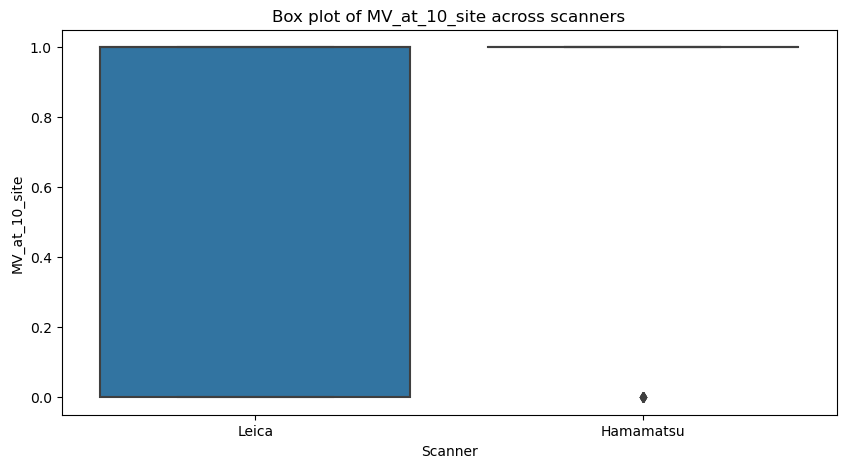

/home/mxn2498/miniconda3/envs/search1/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mxn2498/miniconda3/envs/search1/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/mxn2498/miniconda3/envs/search1/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mxn2498/miniconda3/envs/search1/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and wil

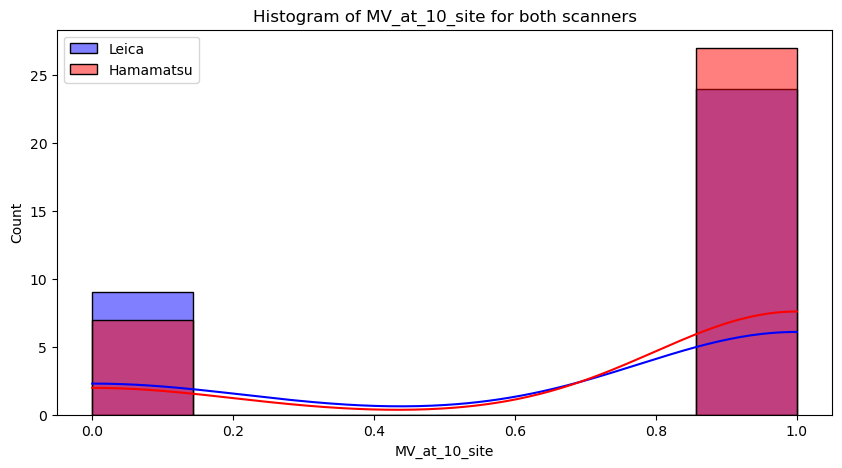

/home/mxn2498/miniconda3/envs/search1/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mxn2498/miniconda3/envs/search1/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mxn2498/miniconda3/envs/search1/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


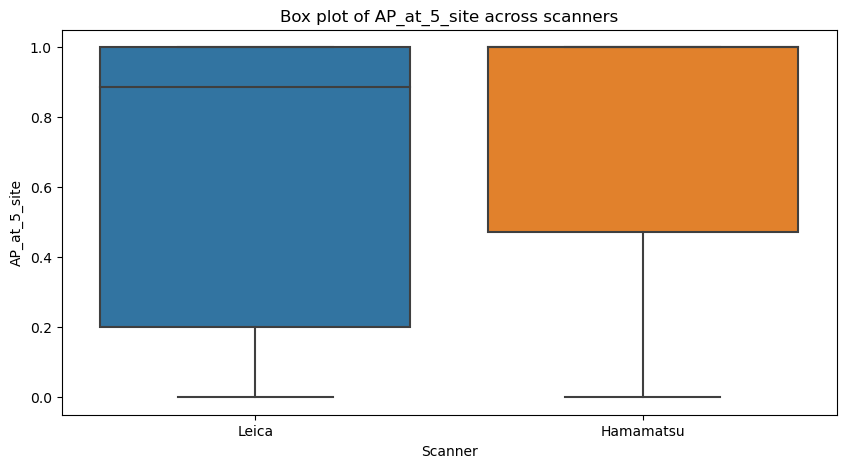

/home/mxn2498/miniconda3/envs/search1/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mxn2498/miniconda3/envs/search1/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/mxn2498/miniconda3/envs/search1/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mxn2498/miniconda3/envs/search1/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and wil

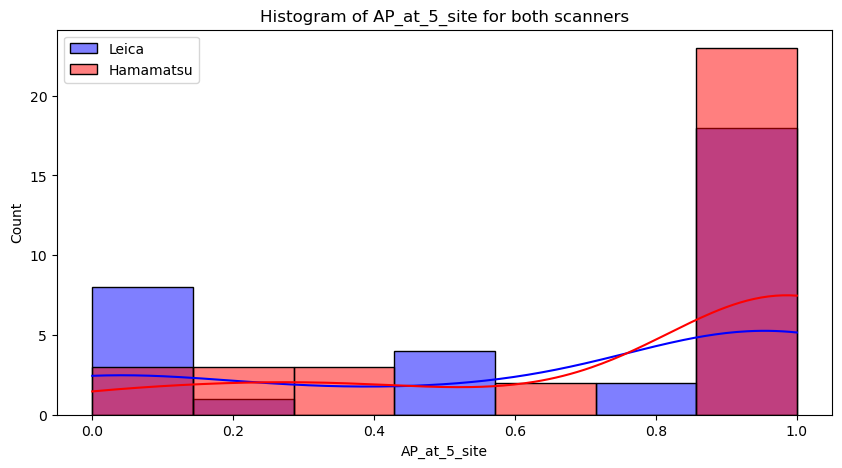

/home/mxn2498/miniconda3/envs/search1/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mxn2498/miniconda3/envs/search1/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mxn2498/miniconda3/envs/search1/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


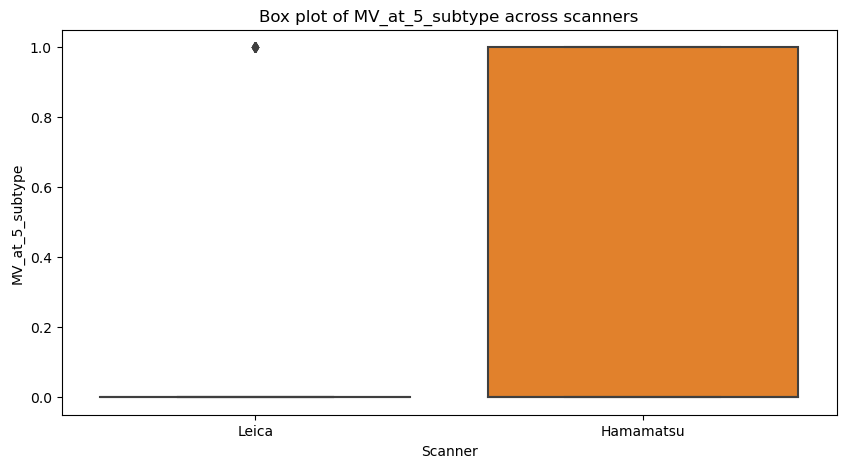

/home/mxn2498/miniconda3/envs/search1/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mxn2498/miniconda3/envs/search1/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/mxn2498/miniconda3/envs/search1/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mxn2498/miniconda3/envs/search1/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and wil

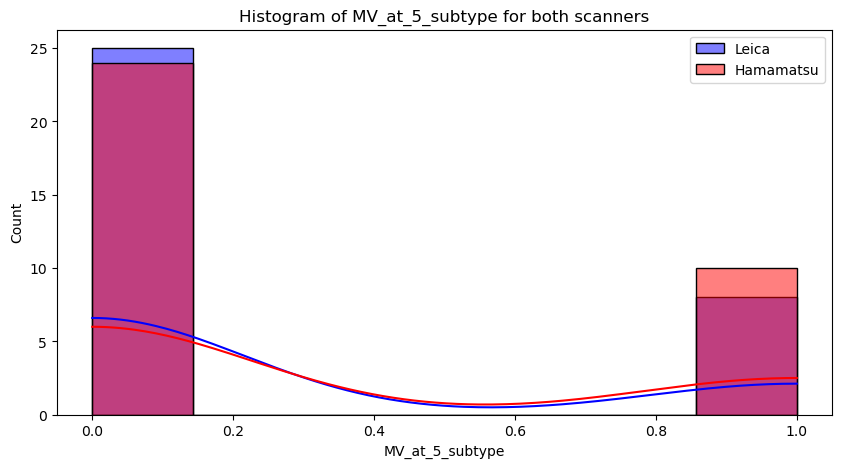

/home/mxn2498/miniconda3/envs/search1/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mxn2498/miniconda3/envs/search1/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mxn2498/miniconda3/envs/search1/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


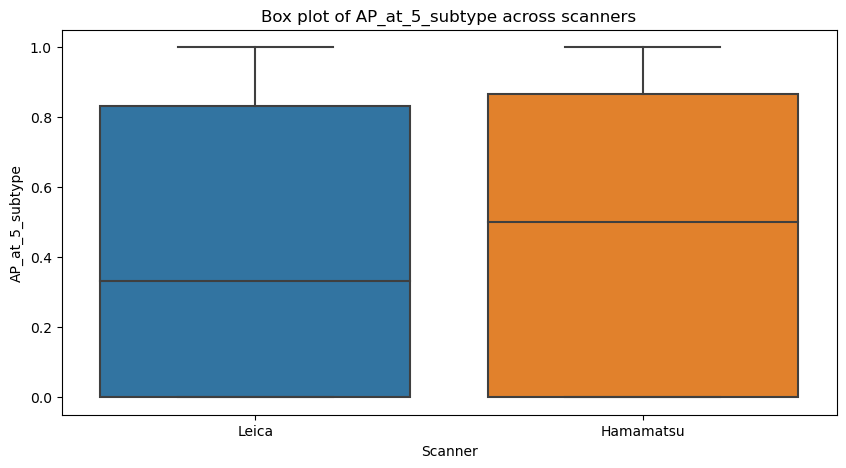

/home/mxn2498/miniconda3/envs/search1/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mxn2498/miniconda3/envs/search1/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/mxn2498/miniconda3/envs/search1/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mxn2498/miniconda3/envs/search1/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and wil

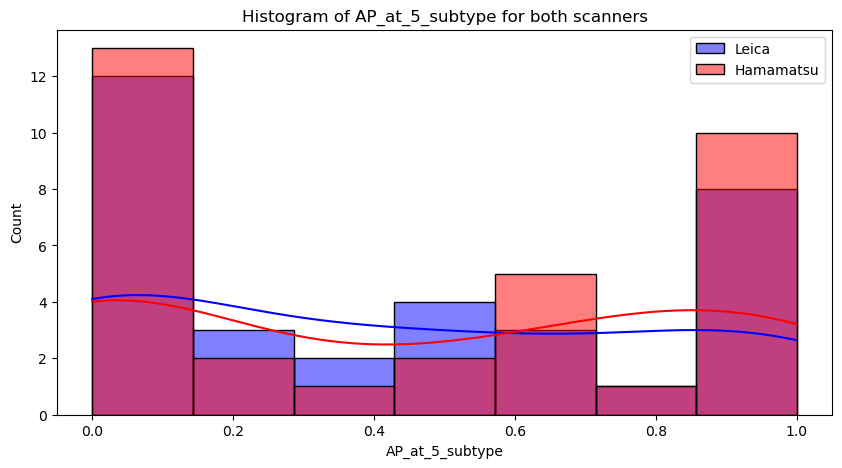

In [7]:
# Plotting for t-test and Mann-Whitney U Test
for metric in score_columns_site:
    plt.figure(figsize=(10, 5))
    
    # Boxplot
    data_to_plot = pd.concat([df_Leica_site[[metric]].assign(Scanner='Leica'), df_Hamamatsu_site[[metric]].assign(Scanner='Hamamatsu')])
    sns.boxplot(x='Scanner', y=metric, data=data_to_plot)
    plt.title(f'Box plot of {metric} across scanners')
    plt.show()
    
    # Histogram
    plt.figure(figsize=(10, 5))
    sns.histplot(df_Leica_site[metric], label='Leica', kde=True, color='blue', alpha=0.5)
    sns.histplot(df_Hamamatsu_site[metric], label='Hamamatsu', kde=True, color='red', alpha=0.5)
    plt.legend()
    plt.title(f'Histogram of {metric} for both scanners')
    plt.show()

for metric in score_columns_subtype:
    plt.figure(figsize=(10, 5))
    
    # Boxplot
    data_to_plot = pd.concat([df_Leica_subtype[[metric]].assign(Scanner='Leica'), df_Hamamatsu_subtype[[metric]].assign(Scanner='Hamamatsu')])
    sns.boxplot(x='Scanner', y=metric, data=data_to_plot)
    plt.title(f'Box plot of {metric} across scanners')
    plt.show()
    
    # Histogram
    plt.figure(figsize=(10, 5))
    sns.histplot(df_Leica_subtype[metric], label='Leica', kde=True, color='blue', alpha=0.5)
    sns.histplot(df_Hamamatsu_subtype[metric], label='Hamamatsu', kde=True, color='red', alpha=0.5)
    plt.legend()
    plt.title(f'Histogram of {metric} for both scanners')
    plt.show()

/home/mxn2498/miniconda3/envs/search1/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mxn2498/miniconda3/envs/search1/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mxn2498/miniconda3/envs/search1/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


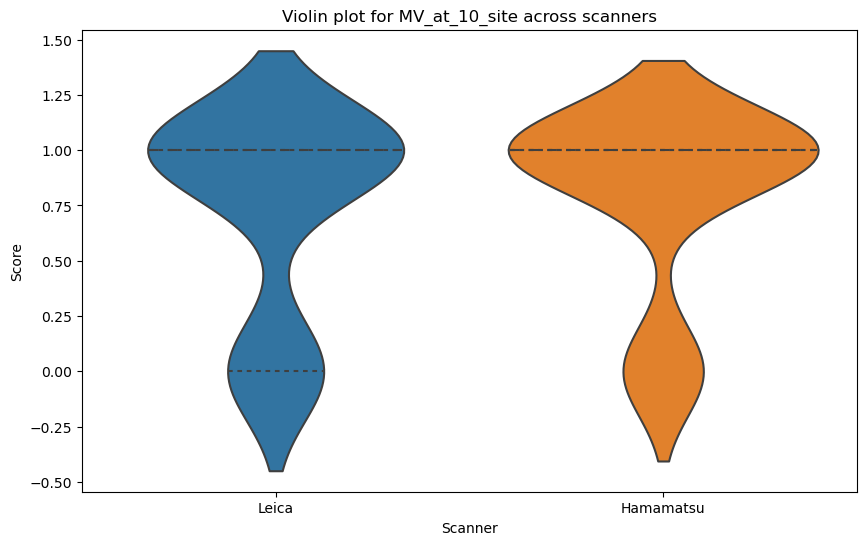

/home/mxn2498/miniconda3/envs/search1/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mxn2498/miniconda3/envs/search1/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mxn2498/miniconda3/envs/search1/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


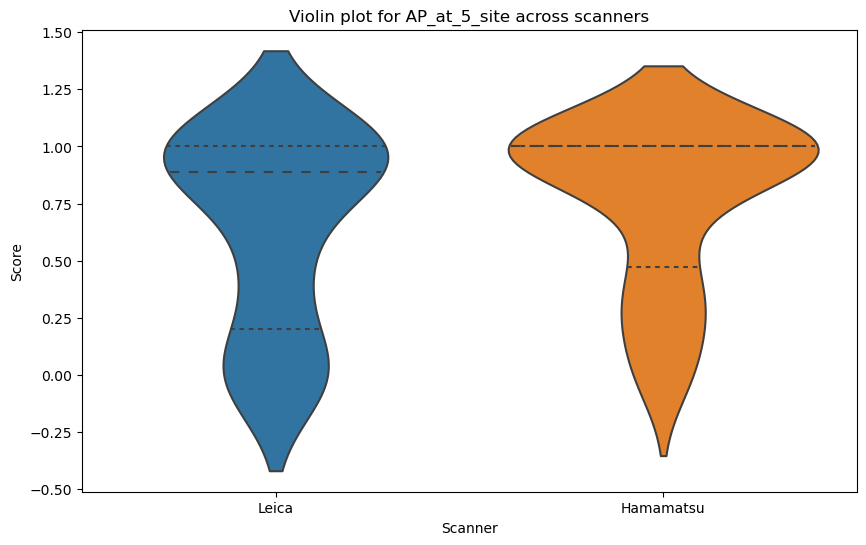

/home/mxn2498/miniconda3/envs/search1/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mxn2498/miniconda3/envs/search1/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mxn2498/miniconda3/envs/search1/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


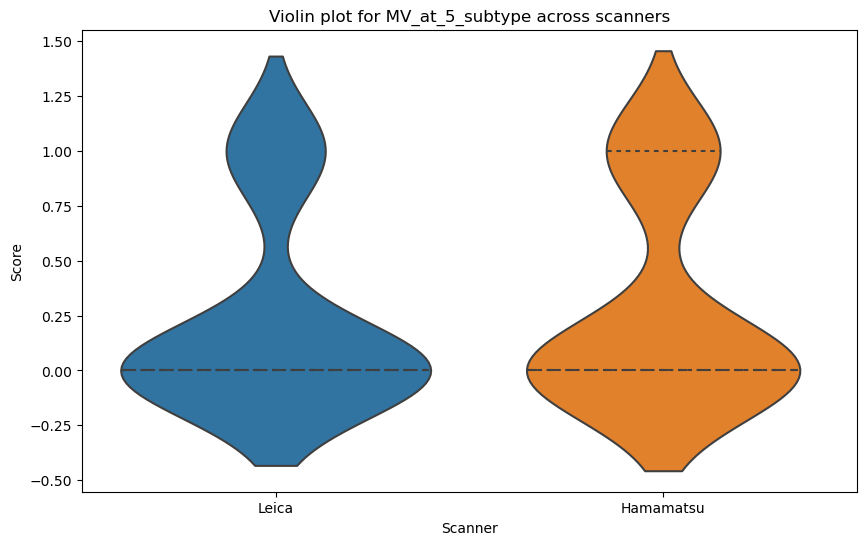

/home/mxn2498/miniconda3/envs/search1/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mxn2498/miniconda3/envs/search1/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mxn2498/miniconda3/envs/search1/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


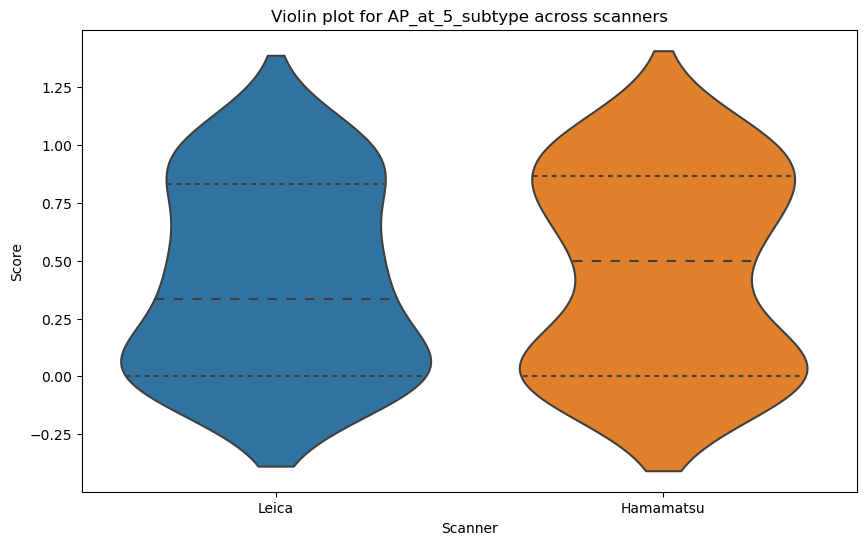

In [8]:
# Merging the two dataframes for plotting purposes
df_Leica_site['scanner'] = 'Leica'
df_Hamamatsu_site['scanner'] = 'Hamamatsu'
combined_df = pd.concat([df_Leica_site, df_Hamamatsu_site], ignore_index=True)

for metric in score_columns_site:
    plt.figure(figsize=(10, 6))
    sns.violinplot(x='scanner', y=metric, data=combined_df, inner="quartile")
    plt.title(f'Violin plot for {metric} across scanners')
    plt.ylabel('Score')
    plt.xlabel('Scanner')
    plt.show()

df_Leica_subtype['scanner'] = 'Leica'
df_Hamamatsu_subtype['scanner'] = 'Hamamatsu'
combined_df = pd.concat([df_Leica_subtype, df_Hamamatsu_subtype], ignore_index=True)

for metric in score_columns_subtype:
    plt.figure(figsize=(10, 6))
    sns.violinplot(x='scanner', y=metric, data=combined_df, inner="quartile")
    plt.title(f'Violin plot for {metric} across scanners')
    plt.ylabel('Score')
    plt.xlabel('Scanner')
    plt.show()